In [1]:
import numpy as np
# import tensorflow as tf
from tensorflow import keras
# import tensorflow
from tensorflow.keras.layers import BatchNormalization, Dense, Input, BatchNormalization
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import GaussianNoise


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import GaussianNoise

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, GaussianNoise, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


2023-11-01 15:35:43.832432: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, Activation, Flatten, MaxPooling2D,Input,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.framework import ops
from binarization_utils import *

In [3]:
resid_levels = True
BINARY = False
LOGIC_SHRINKAGE = False
custom_rand_seed = 1

In [4]:
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

data = []
val_data = []

In [6]:
def sign_activation(x):
    return tf.sign(x)

In [7]:
def autoenco(k,n,SNRs):
    BER = []
    R = float(k/n)
    Nt = 10000
    M = 2**k
    lr = 0.001 # 0.001 by default

    
    global data
    global val_data


    label = np.random.randint(M,size=Nt)
    data = [] # one-hot encoded


    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp) 


    data = np.array(data)


#     autoencoder = Sequential()
#     autoencoder.add(Dense(M, activation='relu', input_shape=(M,), name='input_layer'))
#     autoencoder.add(Dense(n, activation='linear', name='encoder_layer_1'))
#     autoencoder.add(BatchNormalization(name='encoder_batchnorm_layer'))
    
    
    autoencoder = Sequential()
    autoencoder.add(binary_dense(levels=resid_levels, n_in=M, n_out=M, input_shape=(M,), BINARY=BINARY, LOGIC_SHRINKAGE=LOGIC_SHRINKAGE, custom_rand_seed=custom_rand_seed, name="input_layer"))
    autoencoder.add(Activation(sign_activation)) # sign activation function
    
    autoencoder.add(binary_dense(levels=resid_levels, n_in=M, n_out=n, BINARY=BINARY, LOGIC_SHRINKAGE=LOGIC_SHRINKAGE, custom_rand_seed=custom_rand_seed, name="encoder_layer_1"))
    autoencoder.add(Activation(sign_activation))  # sign activation function
    
    autoencoder.add(BatchNormalization(name='encoder_batchnorm_layer'))

    
    
    
    EbNo_train = 10 ** (0.7)
    noise_value = np.sqrt(1/(2*R*EbNo_train))
    
    
    autoencoder.add(GaussianNoise(noise_value))
    
    
#     autoencoder.add(Dense(M, activation='relu', name='decoder_layer_1'))
#     autoencoder.add(Dense(M, activation='softmax', name='decoder_layer_2'))
#     #sgd = SGD(lr=0.001)
#     autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
    
    
    
    autoencoder.add(binary_dense(levels=resid_levels, n_in=n, n_out=M, BINARY=BINARY, LOGIC_SHRINKAGE=LOGIC_SHRINKAGE, custom_rand_seed=custom_rand_seed, name="decoder_layer_1"))
    autoencoder.add(Activation(sign_activation))  # sign activation function
    
    autoencoder.add(binary_dense(levels=resid_levels, n_in=M, n_out=M, BINARY=BINARY, LOGIC_SHRINKAGE=LOGIC_SHRINKAGE, custom_rand_seed=custom_rand_seed, name="decoder_layer_2"))
    autoencoder.add(Activation('softmax'))
    
    
    optimizer = Adam(learning_rate = lr)
    autoencoder.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])
    
    
    print(autoencoder.summary())
    
    
    
    N_val = 8000  #size of val data
    val_label = np.random.randint(M,size=N_val)
    val_data = []
    
    for i in val_label:
        temp = np.zeros(M)
        temp[i] = 1
        val_data.append(temp)
    
    val_data = np.array(val_data)
    
    


    history = autoencoder.fit(data, data,epochs=30,
                              batch_size=300,
                              validation_data=(val_data, val_data),
                              callbacks=[ModelCheckpoint(save_best_only=True, 
                                                         filepath="ok")])
 
    
    global train_loss 
    global val_loss
    global train_accuracy
    global val_accuracy


    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    train_accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    

#     encoder = Sequential()
#     encoder.add(BatchNormalization(input_shape=(M,), name='encoder_2_input_layer_with_batchnorm'))
#     encoded_input = Input(shape=(n,))
    


    return BER

In [8]:
# data.shape

In [9]:
# val_data.shape

In [10]:
# use k =3 and n = 7
SNRs = np.arange(1.0,18.0,0.5)

autoenco(3, 7, SNRs)


	def call(self, x,mask=None):

		#np.random.seed(self.custom_rand_seed)
		#tf.set_random_seed(self.rand_seed)
		#random.seed(self.rand_seed)

		constraint_gamma=K.abs(self.gamma)#K.clip(self.gamma,0.01,10)
		if self.levels==1 or self.first_layer==True:
			if self.BINARY==False:
				self.clamped_w=constraint_gamma*K.clip(self.w,-1,1)
			else:
				self.clamped_w=constraint_gamma*binarize(self.w)
			self.out=K.dot(x,self.clamped_w)
		elif self.levels==2:
			if self.LUT==True:

				if self.LOGIC_SHRINKAGE==True:

					#SHRINKAGE
                #Stacking c coef	ficients to create c_mat1 and c_mat2 tensors
					c_mat1=self.c_param[0 : 2**self.k_lut, :, :]
					c_mat2=self.c_param[2**self.k_lut : (2**self.k_lut)*2, :, :]

					c_mat1=tf.reshape(c_mat1,(1,2**self.k_lut,self.n_in*self.n_out))                
					c_mat2=tf.reshape(c_mat2,(1,2**self.k_lut,self.n_in*self.n_out))
       
					c_mat1=tf.transpose(c_mat1,(2,0,1))
					c_mat2=tf.transpose(c_mat2,(2,0,1))
            
					c_mat1=tf

2023-11-01 15:35:47.105543: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-01 15:35:47.370489: E tensorflow/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-01 15:35:47.370549: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 5310f4639566
2023-11-01 15:35:47.370558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 5310f4639566
2023-11-01 15:35:47.370664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.1
2023-11-01 15:35:47.370691: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.1
2023-11-01 15:35:47.370698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.82.1
2023-11-01 15:35:47.383833: I tensorflow/core/platform/pro

Epoch 1/30
10000/10000 [==============================] - 1s 51us/sample - loss: 2.6424 - acc: 0.0657 - val_loss: 2.5227 - val_acc: 0.0000e+00
Epoch 2/30
10000/10000 [==============================] - 0s 10us/sample - loss: 2.4294 - acc: 0.0854 - val_loss: 2.3806 - val_acc: 0.0000e+00
Epoch 3/30
10000/10000 [==============================] - 0s 9us/sample - loss: 2.2520 - acc: 0.1371 - val_loss: 2.2172 - val_acc: 0.1222
Epoch 4/30
10000/10000 [==============================] - 0s 9us/sample - loss: 2.0919 - acc: 0.1770 - val_loss: 2.0464 - val_acc: 0.2501
Epoch 5/30
10000/10000 [==============================] - 0s 9us/sample - loss: 1.9630 - acc: 0.2101 - val_loss: 1.9239 - val_acc: 0.1279
Epoch 6/30
10000/10000 [==============================] - 0s 9us/sample - loss: 1.8354 - acc: 0.2612 - val_loss: 1.7854 - val_acc: 0.1279
Epoch 7/30
10000/10000 [==============================] - 0s 9us/sample - loss: 1.7233 - acc: 0.2853 - val_loss: 1.6559 - val_acc: 0.1279
Epoch 8/30
10000/10000 [

[]

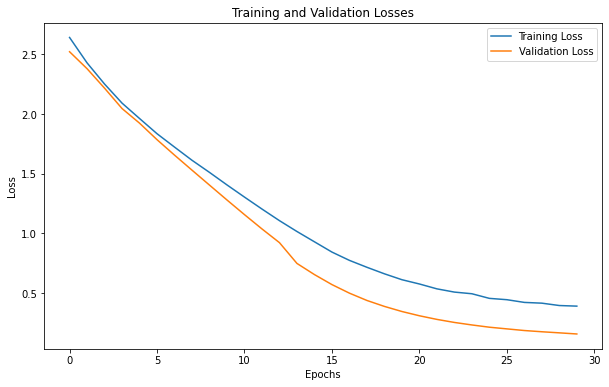

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

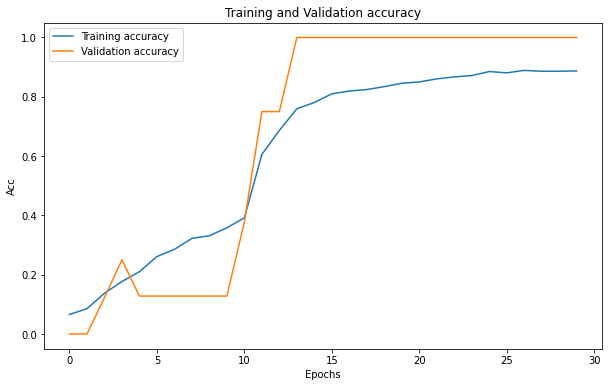

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [14]:
# val_accuracy